# Armball Goal Babbling with Manifold Learning

In this notebook, we assess performances of goal babbling for exploration using learned Manifold. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Circle
from explauto.environment.dynamic_environment import DynamicEnvironment
from explauto.environment.modular_environment import FlatEnvironment, HierarchicalEnvironment
from explauto.utils import bounds_min_max
from explauto.environment.environment import Environment
from explauto.environment.simple_arm.simple_arm import joint_positions
from explauto.utils.utils import rand_bounds
import sys
sys.path.append("../src")
import simulation 
import workbench
import architectures
import utils
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import LocallyLinearEmbedding, Isomap
from sklearn.decomposition import PCA
import networkx as nx
import seaborn
import scipy.spatial.distance
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

In [2]:
# We define Experiment Name
expe_name = "Exp7"

In [3]:
%%bash
rm -rf logs/Exp7

## Training the model

In [6]:
# We generate simulation
sim = simulation.TranslatingBallSimulation()
emb_size = 2

# We set the model
model = LocallyLinearEmbedding(n_components=2, eigen_solver='dense')

# We generate data
def gen_func():
    coord = np.random.uniform(low=0., high=1., size=sim.nb_params())
    x = sim.draw(list(coord), depth=1).ravel()
    return x, x
X = np.array([gen_func()[0] for i in range(int(1e4))])

# We fit the model
vals = model.fit_transform(X)
vals_min = vals.ravel().min()
vals_max = vals.ravel().max()

## Defining the Environment

In [7]:
def arm_lengths(n_joints):
    if n_joints == 3:
        return [0.5, 0.3, 0.2]
    elif n_joints == 7:
        return [0.3, 0.2, 0.2, 0.1, 0.1, 0.05, 0.05]
    else:
        return [1./n_joints] * n_joints
    
class Arm(Environment):
    use_process = True
    def __init__(self, m_mins, m_maxs, s_mins, s_maxs,
                 lengths, angle_shift, rest_state):
        
        Environment.__init__(self, m_mins, m_maxs, s_mins, s_maxs)

        self.lengths = lengths
        self.angle_shift = angle_shift
        self.rest_state = rest_state
        self.reset()
        
    def reset(self):
        self.logs = []
        self.lines = None
        
    def compute_motor_command(self, m):
        return bounds_min_max(m, self.conf.m_mins, self.conf.m_maxs)

    def compute_sensori_effect(self, m):
        a = self.angle_shift + np.cumsum(np.array(m))
        a_pi = np.pi * a 
        hand_pos = np.array([np.sum(np.cos(a_pi)*self.lengths), np.sum(np.sin(a_pi)*self.lengths)])
        angle = np.mod(a[-1] + 1, 2) - 1
        self.logs.append(m)
        return [hand_pos[0], hand_pos[1], angle]    
        
    def plot(self, ax, i, **kwargs_plot):
        m = self.logs[i]
        angles = np.array(m)
        angles[0] += self.angle_shift
        x, y = joint_positions(angles, self.lengths, 'std')
        x, y = [np.hstack((0., a)) for a in x, y]
        l = []
        l += ax.plot(x, y, 'grey', lw=4, animated=True, **kwargs_plot)
        l += ax.plot(x[0], y[0], 'sk', ms=8, animated=True, **kwargs_plot)
        for i in range(len(self.lengths)-1):
            l += ax.plot(x[i+1], y[i+1], 'ok', ms=8, animated=True, **kwargs_plot)
        l += ax.plot(x[-1], y[-1], 'or', ms=8, animated=True, **kwargs_plot)
        self.lines = l
        return l 
        
    def plot_update(self, ax, i, **kwargs_plot):
        if self.lines is None:
            self.plot(ax, 0, **kwargs_plot)
        m = self.logs[i]
        angles = np.array(m)
        angles[0] += self.angle_shift
        x, y = joint_positions(angles, self.lengths, 'std')
        x, y = [np.hstack((0., a)) for a in x, y]
        l = []
        l += [[x, y]]
        l += [[x[0], y[0]]]
        for i in range(len(self.lengths)-1):
            l += [[x[i+1], y[i+1]]]
        l += [[x[-1], y[-1]]]
        for (line, data) in zip(self.lines, l):
            line.set_data(data[0], data[1])
        return self.lines

        
class Ball(Environment):
    
    def __init__(self, m_mins, m_maxs, s_mins, s_maxs,
                 size, initial_position, ball_type="magnetic", color='y', random_ball_noise=0.2):
        
        Environment.__init__(self, m_mins, m_maxs, s_mins, s_maxs)

        self.ball_type = ball_type
        self.size = size
        self.size_sq = size * size
        self.color = color
        self.initial_position = initial_position
        self.random_ball_noise = random_ball_noise
        self.reset()
    
    def reset(self):
        self.move = False
        self.circle = None
        self.pos = np.array(self.initial_position)
        self.logs = []
        
    def compute_motor_command(self, m):
        return m

    def compute_sensori_effect(self, m):
        if self.ball_type == "magnetic":
            if self.move or ((m[0] - self.pos[0]) ** 2 + (m[1] - self.pos[1]) ** 2 < self.size_sq):
                self.pos = m[0:2]
                self.move = 1
        elif self.ball_type == "random":
            self.pos = self.pos + np.random.randn(2) * self.random_ball_noise
             
        self.logs.append([self.pos,
                          self.move])
        return list(self.pos)
    
    def plot(self, ax, i, **kwargs_plot):
        self.logs = self.logs[-50:]
        pos = self.logs[i][0]     
        self.circle = Circle((pos[0], pos[1]), self.size, fc=self.color, animated=True, **kwargs_plot)
        ax.add_patch(self.circle)  
        return [self.circle]
        
    def plot_update(self, ax, i, **kwargs_plot):
        if self.circle is None:
            self.plot(ax, 0, **kwargs_plot)
        self.logs = self.logs[-50:]
        pos = self.logs[i][0]    
        self.circle.center = tuple(pos)
        return [self.circle]
        
        
class ArmBall(DynamicEnvironment):
    
    def __init__(self, n_joints=3, n_dmp_basis=3, goal_size=1.):
        
        arm_config = dict(
            m_mins=[-1.] * n_joints,
            m_maxs=[1.] * n_joints, 
            s_mins=[-1.] * 3,
            s_maxs=[1.] * 3, 
            lengths=arm_lengths(n_joints), 
            angle_shift=0.5,
            rest_state=[0.] * n_joints)
        
        ball_config = dict(
            m_mins=[-1.] * 2,
            m_maxs=[1.] * 2, 
            s_mins=[-1.] * 2,
            s_maxs=[1.] * 2,
            size=0.1,
            initial_position=[0.6, 0.3],
            color="b")
        
        arm_ball_cfg = dict(
            m_mins=[-1.] * n_joints,
            m_maxs=[1.] * n_joints,
            s_mins=[-1.] * 2,
            s_maxs=[1.] * 2,
            top_env_cls=Ball, 
            lower_env_cls=Arm, 
            top_env_cfg=ball_config, 
            lower_env_cfg=arm_config, 
            fun_m_lower= lambda m:m,
            fun_s_lower=lambda m,s:s[0:2],
            fun_s_top=lambda m,s_lower,s:s)
        
        dynamic_environment_config = dict(
            env_cfg=arm_ball_cfg,
            env_cls=HierarchicalEnvironment,
            m_mins=[-1.] * n_joints * n_dmp_basis, 
            m_maxs=[1.] * n_joints * n_dmp_basis, 
            s_mins=[-goal_size] * 2,
            s_maxs=[goal_size] * 2,
            n_bfs=n_dmp_basis,
            move_steps=50, 
            n_dynamic_motor_dims=n_joints,
            n_dynamic_sensori_dims=2,
            sensori_traj_type="end_point",
            max_params=1000)
        
        DynamicEnvironment.__init__(self, **dynamic_environment_config)
        
        self.fig = None
        self.ax = None
        
    def random_motor(self): 
        return self.random_motors()[0]
    
    
    def plot_frame(self, i):
        self.ax.cla()
        self.env.lower_env.plot(self.ax, i) # Plot Arm
        self.env.top_env.plot(self.ax, i) # Plot Ball
        self.ax.set_aspect('equal')
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        
    def fig2data(self):
        """
        @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
        @param fig a matplotlib figure
        @return a numpy 3D array of RGBA values
        """
        # draw the renderer
        self.fig.canvas.draw ( )

        # Get the RGBA buffer from the figure
        w,h = self.fig.canvas.get_width_height()
        buf = np.fromstring (self.fig.canvas.tostring_argb(), dtype=np.uint8 )
        buf.shape = ( w, h,4 )

        # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
        buf = np.roll ( buf, 3, axis = 2 )
        return buf
    
    
    def compute_sensori_effect(self, m_traj):
        s = self.env.update(m_traj, reset=False, log=False)
        self.s_traj = s
        #self.plot_frame(self.end_point-1)
        #x = self.fig2data()
        
        z = s[-1]
        
        return z
    

In [8]:
def state_2_latent(eng_coords):
    """
    This function allows to turn engineered coordinates into latent coordinates.
    """
    coords = (eng_coords + 1)/2.
    image = sim.draw(list(coords)).reshape([1,-1]).squeeze()
    latent = model.transform([image]).squeeze()

    return latent

def sample_latent():
    """
    This function allows to sample following the latent prior
    """
    
    return np.random.uniform(vals_max,vals_min,emb_size)

## Experiments

In [17]:
from explauto.sensorimotor_model.non_parametric import NonParametric
from explauto.utils import rand_bounds
from explauto.utils.config import make_configuration

# We define the parameters of the simulation
n_joints = 7
n_dmp_basis = 3
goal_size = 10.

# We set the parameters of the exploration
iterations = int(1e3)        # Number of iterations
sigma_explo_ratio = 0.05     # Exploration noise (standard deviation)

# We initialize lists of states and latents
state_list = []
latent_list = []

# We initialize the simulation environment
environment = ArmBall( n_joints, n_dmp_basis, goal_size)
conf = make_configuration(environment.conf.m_mins, environment.conf.m_maxs, np.zeros(emb_size), np.ones(emb_size))
sm_model = NonParametric(conf, sigma_explo_ratio=sigma_explo_ratio, fwd='NN', inv='NN')

# We run the exploration
for i in tqdm(range(iterations)):
    # Random Babbling
    if i < 100 or np.random.random() < 0.2: 
        m = environment.random_motors()[0]
    # Goal Babbling
    else:
        # Change here the sampling logic
        s_goal = sample_latent()
        m = sm_model.inverse_prediction(s_goal)
    # We perform the motor action
    s = environment.update(m)
    z = state_2_latent(s)
    # We compute the latent dimension
    state_list += [s] # ball positions at the end of movements
    latent_list += [z] # latent representation of ball position
    sm_model.update(m, z) # update sensorimotor model
    
# We transform lists to arrays
state_list = np.array(state_list)
latent_list = np.array(latent_list)

### Figure 1: Exploration in Latent and State Space

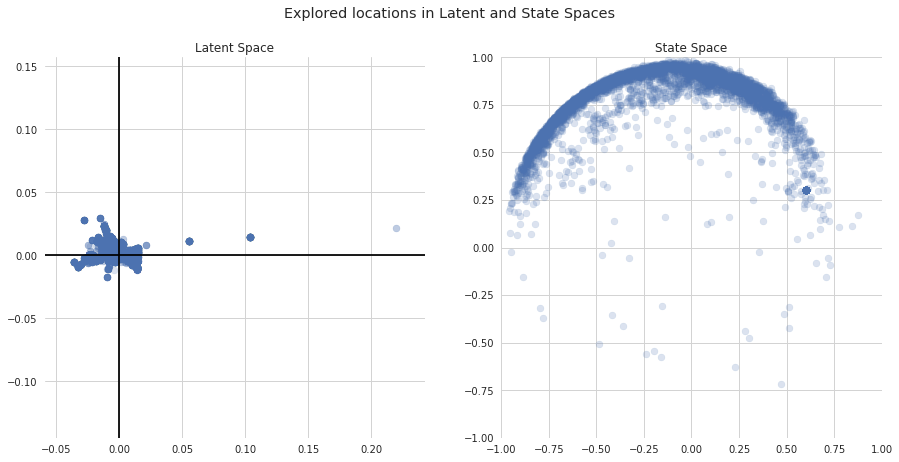

In [14]:
# We plot explored locations in latent and state space
fig, ax = plt.subplots(1,2, figsize=(15,7))
pca = PCA(n_components=2)
pca.fit(latent_list)
reduced_latent_list = pca.transform(latent_list)
ax[0].scatter(reduced_latent_list[:,0], reduced_latent_list[:,1], alpha=.2);
ax[0].set_title("Latent Space")
ax[0].grid(color="lightGrey")
ax[0].set_facecolor('white')
ax[0].axis('equal')
ax[0].axhline(0, color='black')
ax[0].axvline(0, color='black')
ax[1].scatter(state_list[:,0], state_list[:,1], alpha=.2);
ax[1].set_title("State Space")
ax[1].set_xlim([-1,1])  
ax[1].set_ylim([-1,1])
ax[1].grid(color="lightGrey")
ax[1].set_facecolor('white')
fig.suptitle("Explored locations in Latent and State Spaces");
fig.savefig('figures/%s-fig1.pdf'%expe_name)

### Figure 2: Projection of latent neighbours in state space

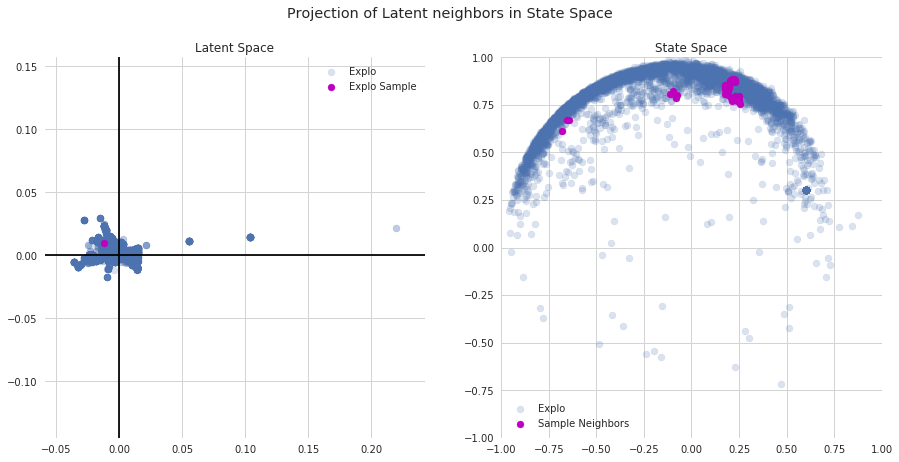

In [11]:
# We select a random latent point achieved and plots its kneighbors in state space
i = 0
while np.array_equal(state_list[i], state_list[0]):
    i = np.random.randint(iterations)
k = 50
# We generate the neighbors model
knn = NearestNeighbors(n_neighbors=k)
knn.fit(latent_list)
neighbors = knn.kneighbors([latent_list[i]], k, return_distance=False).squeeze()
# We plot
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(reduced_latent_list[:,0], reduced_latent_list[:,1], label="Explo", alpha=.2);
ax[0].scatter(reduced_latent_list[i,0], reduced_latent_list[i,1], label="Explo Sample", color="m");
ax[0].legend()
ax[0].grid(color="lightGrey")
ax[0].set_facecolor('white')
ax[0].set_title("Latent Space")
ax[0].axis('equal')
ax[0].axhline(0, color='black')
ax[0].axvline(0, color='black')
ax[1].scatter(state_list[:,0], state_list[:,1], label="Explo", alpha = .2);
ax[1].scatter(state_list[neighbors,0], state_list[neighbors,1], label="Sample Neighbors", c="m");
ax[1].set_title("State Space")
ax[1].set_xlim([-1,1])  
ax[1].set_ylim([-1,1])
ax[1].grid(color="lightGrey")
ax[1].set_facecolor('white')
ax[1].legend()
fig.suptitle("Projection of Latent neighbors in State Space");
fig.savefig('figures/%s-fig2.pdf'%expe_name)

### Figure 3: Projection of State Neighbors in Latent Space

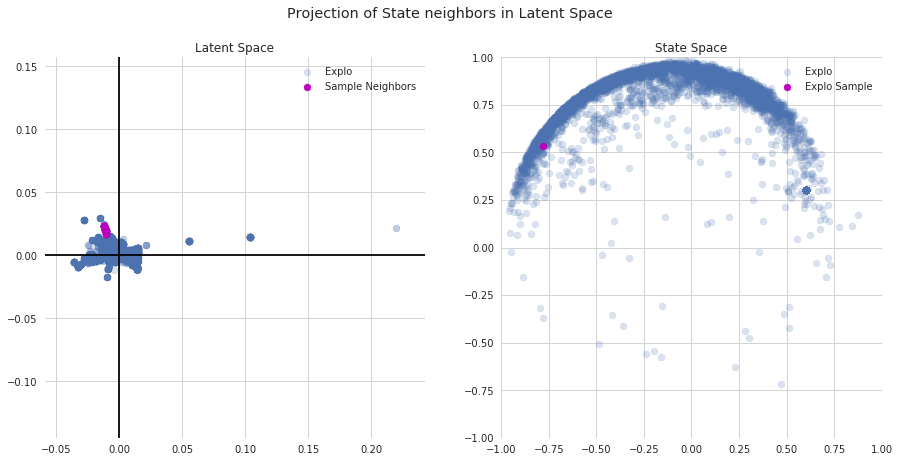

In [12]:
# We select a random state point achieved and plots its kneighbors in latent space
i = 0
while np.array_equal(latent_list[i], latent_list[0]):
    i = np.random.randint(iterations)
k = 50
# We generate the neighbors model
knn = NearestNeighbors(n_neighbors=k)
knn.fit(state_list)
neighbors = knn.kneighbors([state_list[i]], k, return_distance=False).squeeze()
# We plot
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(reduced_latent_list[:,0], reduced_latent_list[:,1], label="Explo", alpha=.2);
ax[0].scatter(reduced_latent_list[neighbors,0],reduced_latent_list[neighbors,1],color="m",label="Sample Neighbors");
ax[0].set_title("Latent Space")
ax[0].grid(color="lightGrey")
ax[0].set_facecolor('white')
ax[0].legend()
ax[0].axis('equal')
ax[0].axhline(0, color='black')
ax[0].axvline(0, color='black')
ax[1].scatter(state_list[:,0], state_list[:,1], label="Explo", alpha=.2);
ax[1].scatter(state_list[i,0], state_list[i,1],color="m", label = "Explo Sample");
ax[1].set_title("State Space")
ax[1].set_xlim([-1,1])  
ax[1].set_ylim([-1,1])
ax[1].grid(color="lightGrey")
ax[1].set_facecolor('white')
ax[1].legend()
fig.suptitle("Projection of State neighbors in Latent Space");
fig.savefig('figures/%s-fig3.pdf'%expe_name)

### Figure 4:  Nearest Neighbors of random samples drawn in Latent and State Space

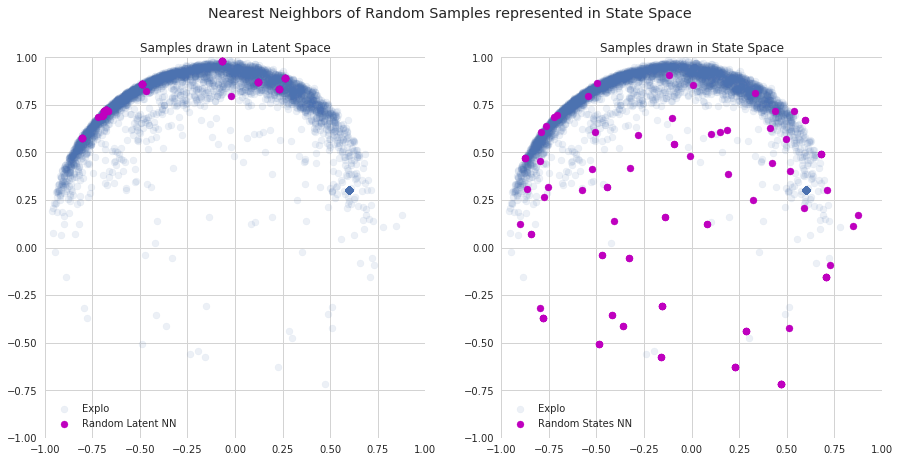

In [13]:
# We generate random goal
n_samples = 100
goals_state = np.random.uniform(1, -1, [n_samples,2])
goals_latent = np.array([sample_latent() for i in range(n_samples)])
k = 1
# We generate the neighbors model
knn_state = NearestNeighbors(n_neighbors=k)
knn_state.fit(state_list)
neighbors_state = knn_state.kneighbors(goals_state, k, return_distance=False).squeeze()
knn_latent = NearestNeighbors(n_neighbors=k)
knn_latent.fit(latent_list)
neighbors_latent = knn_latent.kneighbors(goals_latent, k, return_distance=False).squeeze()
# We plot
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(state_list[:,0], state_list[:,1], label="Explo", alpha=.1);
ax[0].scatter(state_list[neighbors_latent.ravel(),0], state_list[neighbors_latent.ravel(),1], 
              color="m", label = "Random Latent NN");
ax[0].set_title("Samples drawn in Latent Space")
ax[0].set_xlim([-1,1])  
ax[0].set_ylim([-1,1])
ax[0].grid(color="lightGrey")
ax[0].set_facecolor('white')
ax[0].legend()
ax[1].scatter(state_list[:,0], state_list[:,1], label="Explo", alpha=.1);
ax[1].scatter(state_list[neighbors_state.ravel(),0], state_list[neighbors_state.ravel(),1], 
              color="m", label = "Random States NN");
ax[1].set_title("Samples drawn in State Space")
ax[1].set_xlim([-1,1])  
ax[1].set_ylim([-1,1])
ax[1].grid(color="lightGrey")
ax[1].set_facecolor('white')
ax[1].legend()
fig.suptitle("Nearest Neighbors of Random Samples represented in State Space");
fig.savefig('figures/%s-fig4.pdf'%expe_name)

### Measure 1: Goal Babbling Exploration 

This measure is intended to check whether the exploration works using the latent representation

In [18]:
# Measure of exploration: discretize as a grid of size gs, count reached cells
def compute_explo(data, mins, maxs, gs=10):
    n = len(mins)
    if len(data) == 0:
        return 0
    else:
        assert len(data[0]) == n
        epss = (maxs - mins) / gs
        grid = np.zeros([gs] * n)
        for i in range(len(data)):
            idxs = np.array((data[i] - mins) / epss, dtype=int)
            idxs[idxs>=gs] = gs-1
            idxs[idxs<0] = 0
            grid[tuple(idxs)] = grid[tuple(idxs)] + 1
        grid[grid > 1] = 1
    return np.sum(grid)

explo = compute_explo(state_list, np.array([-1., -1.]), np.array([1., 1.]))
print("Exploration measure: %f" % explo)

Exploration measure: 33.000000


### Measure 2: MSE of inverse model

This measure is intended to show whether the latent representation allows to reach nice performances. 

In [19]:
def compute_average_error(env, model, nb_samples=10000):
    """
    This method computes the average error of direct model
    """
    # We sample random goals in complete state space
    state_goals = np.random.uniform(1, -1, [nb_samples, 2])
    state_achie = np.zeros([nb_samples, 2])
    # We compute the achieved states
    for i in tqdm(range(nb_samples)):        
        latent_goal = state_2_latent(state_goals[i])
        model.mode = "exploit"
        m = model.inverse_prediction(latent_goal)
        s = env.update(m);
        state_achie[i] = s
    # We compute the average error
    err = np.square(np.linalg.norm(state_goals-state_achie , axis=1, ord=2)).mean()
    
    return err
    
err = compute_average_error(environment, sm_model);
print("MSE of Inverse Model: %f"%err)


MSE of Inverse Model: 1.021532


### Measure 3: KL-Div estimation between latent prior and posterior distribution 

This measure is intended to check whether the learned latent representation matches well with our prior, or will a random sampling following our prior will be powerful.

In [15]:
# We generate a bunch of samples from p
n_samples = int(2e4)
s_p = np.array([sample_latent() for i in range(n_samples)]).squeeze()
# We generate a bunch of samples from q
cds = np.random.uniform(high=1., low=0., size=[n_samples, sim.nb_params()])
X_i = np.array([sim.draw(list(cds[i])) for i in range(n_samples)]).reshape([n_samples, -1])
s_q = network.evaluate_latent(X=X_i, disable_progress=True).squeeze()[:,0,:]

In [20]:
# We compute the kldiv
k = 2
while  utils.kldiv(s_q, s_p, k=k) == float("inf") and k<=30:
    clear_output()
    print("Failed with k= %i"%k)
    k += 1
kl = utils.kldiv(s_q, s_p, k=k)
print("KL-Divergence: %f" % kl)

Failed with k= 30
KL-Divergence: inf


### Measure 4: Global Metric Distorsion

This measure is intended to check whether the embedding function distort the metric or not at the global scale (accounting the distancfes between the most secluded points).

In [18]:
# We generate samples
n_samples = int(1e3)
s_i = np.random.uniform(high=1., low=0., size=[n_samples, sim.nb_params()])
# We compute distance matrix in input state space
dims = np.array(sim.get_factor_dims())
X_i = np.zeros([n_samples, dims.sum()])
for i in range(dims.size):
    if dims[i] == 1:
        X_i[:,dims[:i+1].sum()-1] = s_i[:,i]
    if dims[i] == 2:
        X_i[:,dims[:i+1].sum()-2] = np.sin(s_i[:,i]*2*np.pi)/np.pi
        X_i[:,dims[:i+1].sum()-1] = np.cos(s_i[:,i]*2*np.pi)/np.pi
k = 2
conn = False
while conn == False:
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X_i)
    M = knn.kneighbors_graph(X_i, mode='distance')
    graph = nx.from_scipy_sparse_matrix(M)
    conn = nx.is_connected(graph)
    k+= 1
    
distances_i = nx.all_pairs_dijkstra_path_length(graph, cutoff=None, weight='weight')
distances_i = np.array([np.array(a.items())[:,1] for a in np.array(distances_i.items())[:,1]])
# We compute distance matrix in output latent space
s_o = np.array([state_2_latent(np.array(s_i[i])) for i in range(n_samples)]).reshape([n_samples, -1]) 
distances_o = scipy.spatial.distance.pdist(s_o, 'euclidean')
distances_o = scipy.spatial.distance.squareform(distances_o)

In [19]:
# We compute the contraction
contraction = distances_i/(distances_o+1e-6)
print("Mean Contraction: %f"%contraction[np.where(distances_o != 0.)].mean())
print("Min Contraction: %f"%contraction[np.where(distances_o != 0.)].min())
print("Max Contraction: %f"%contraction[np.where(distances_o != 0.)].max())
# We compute the expansion
expansion = distances_o/(distances_i+1e-6)
print("Mean Expansion: %f"%expansion[np.where(distances_i!= 0.)].mean())
print("Min Expansion: %f"%expansion[np.where(distances_i!= 0.)].min())
print("Max Expansion: %f"%expansion[np.where(distances_i!= 0.)].max())
# We compute the distorsion
distorsion = contraction[np.where(distances_o != 0.)].max()*expansion[np.where(distances_i!= 0.)].max()
print("Distorsion: %f"% distorsion)

Mean Contraction: 0.009844
Min Contraction: 0.000236
Max Contraction: 920.665474
Mean Expansion: 164.890029
Min Expansion: 0.000000
Max Expansion: 4241.211975
Distorsion: 3904737.433059


### Measure 5: Local Neighbouring Distorsion

This measure is intended to check whether the local metric is distorded or not (whether the neighbours in state space are neighbours in latent space, and vice versa). 

In [20]:
# We generate samples
n_samples = int(1e4)
s_i = np.random.uniform(high=1., low=0., size=[n_samples, sim.nb_params()])

# We generate coordinates for input space
dims = np.array(sim.get_factor_dims())
X_i = np.zeros([n_samples, dims.sum()])
for i in range(dims.size):
    if dims[i] == 1:
        X_i[:,dims[:i+1].sum()-1] = s_i[:,i]
    if dims[i] == 2:
        X_i[:,dims[:i+1].sum()-2] = np.sin(s_i[:,i]*2*np.pi)/np.pi
        X_i[:,dims[:i+1].sum()-1] = np.cos(s_i[:,i]*2*np.pi)/np.pi
# We compute coordinates for output space
X_o = np.array([state_2_latent(s_i[i]) for i in range(n_samples)])
# We construct graphs
k = 10
# Input graph
knn_i = NearestNeighbors(n_neighbors=k, algorithm="brute", metric='euclidean')
knn_i.fit(X_i)
M_i = knn_i.kneighbors_graph(X_i)
graph_i = nx.from_numpy_matrix(M_i.todense())
# Output graph
knn_o = NearestNeighbors(n_neighbors=k, algorithm='brute', metric="euclidean")
knn_o.fit(X_o)
M_o = knn_o.kneighbors_graph(X_o)
graph_o = nx.from_numpy_matrix(M_o.todense())
# We compute the intersection between the two graphs
graph_int = nx.intersection(graph_i, graph_o)
# We compute the ratios
int_i = float(len(graph_int.edges()))/float(len(graph_i.edges()))
int_o = float(len(graph_int.edges()))/float(len(graph_o.edges()))
print("Edges Ratios of intersection over input: %f" % int_i)
print("Edges Ratios of intersection over output: %f" % int_o)
print("Are the graph isomorphics: %s"%str(nx.is_isomorphic(graph_i, graph_o)))
print("K=%f"%k)

Edges Ratios of intersection over input: 0.611813
Edges Ratios of intersection over output: 0.590945
Are the graph isomorphics: False
K=10.000000
